In [27]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import warnings 
warnings.filterwarnings("ignore")
Path.cwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/Users/adamzh0u/315_RL/cege_test')

## Test Data Generation

In [28]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
n_points = 10000
p, d, q = 5, 2, 5
model = ARIMA(np.random.randn(n_points), order=(p, d, q))
model_fit = model.fit()
water_demand = model_fit.predict(start=0, end=n_points-1)

In [30]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(5, 2, 5)   Log Likelihood              -14322.035
Date:                Mon, 08 Jul 2024   AIC                          28666.070
Time:                        03:27:14   BIC                          28745.382
Sample:                             0   HQIC                         28692.917
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.7055      0.010   -257.955      0.000      -2.726      -2.685
ar.L2         -2.6874      0.030    -90.431      0.000      -2.746      -2.629
ar.L3         -0.9525      0.039    -24.307      0.0

In [31]:
water_demand[100:].min(), water_demand[100:].max()

(-0.3725653572507813, 0.4100972397981657)

## genertate data 

- seed > 100  leak_increase_range=(5, 10)
- seed > 200 leak_increase_range=(4,8)

In [14]:
# generate 10 independent water demands data 
# for seed in range(50):
for seed in range(242,247):
    num_leaks = 12
    df = wd.simulation(seed, num_leaks)
    wd.save(df, seed, num_leaks)

Data saved successfully Data_water_demand_with_leaks_242_12.txt
Data saved successfully Data_water_demand_with_leaks_243_12.txt
Data saved successfully Data_water_demand_with_leaks_244_12.txt
Data saved successfully Data_water_demand_with_leaks_245_12.txt
Data saved successfully Data_water_demand_with_leaks_246_12.txt


## Change leakage rate range

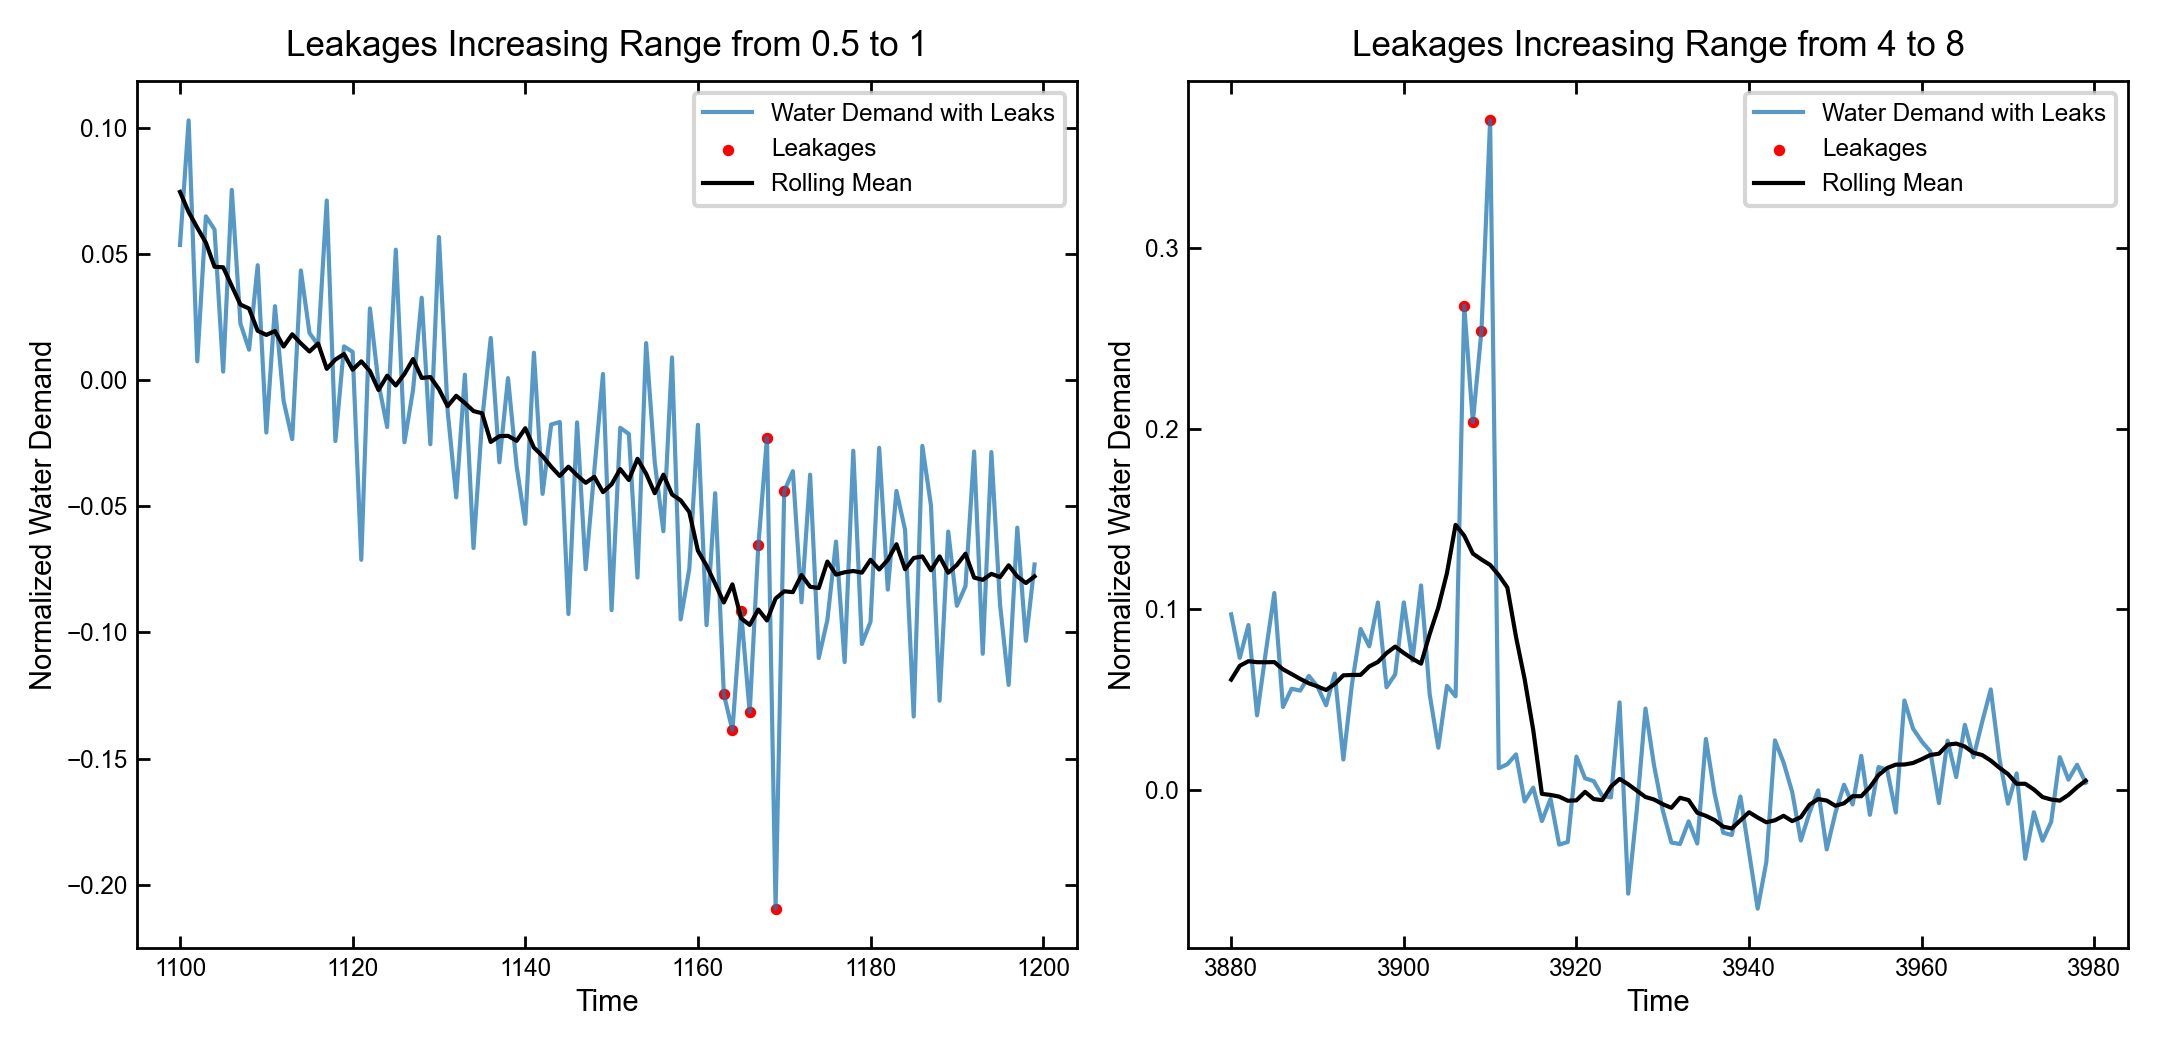

In [83]:
## window size
dft =  wd.load(43, 12) 
ws = 10
dft['rolling_mean'] = dft['WaterDemandWithLeaks'].rolling(window=ws,center=True).mean()

dft2 = wd.load(243, 12)
dft2['rolling_mean'] = dft2['WaterDemandWithLeaks'].rolling(window=ws,center=True).mean()

import src.utils.plot_utils as pu
import matplotlib.pyplot as plt
pu.setup_mpl(as_default=0)

dfp = dft[1100:1200]
dfp2 = dft2[3880:3980]

fig,ax = plt.subplots(1,2, figsize=(3.60236*2, 3.5),dpi=300)

ax[0].plot(dfp.index, dfp['WaterDemandWithLeaks'],
            label='Water Demand with Leaks', alpha=0.75)
ax[0].scatter(dfp[dfp['LeakageLabel'] == 1].index, dfp[dfp['LeakageLabel']
            == 1]['WaterDemandWithLeaks'], color='red', label='Leakages',s=3)
ax[0].plot(dfp.index, dfp['rolling_mean'], label='Rolling Mean', color='black')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Normalized Water Demand')
ax[0].set_title('Leakages Increasing Range from 0.5 to 1')

ax[1].plot(dfp2.index, dfp2['WaterDemandWithLeaks'],
            label='Water Demand with Leaks', alpha=0.75)
ax[1].scatter(dfp2[dfp2['LeakageLabel'] == 1].index, dfp2[dfp2['LeakageLabel']
            == 1]['WaterDemandWithLeaks'], color='red', label='Leakages',s=3)   
ax[1].plot(dfp2.index, dfp2['rolling_mean'], label='Rolling Mean', color='black')
ax[1].legend()

ax[1].set_xlabel('Time')
ax[1].set_ylabel('Normalized Water Demand')
ax[1].set_title('Leakages Increasing Range from 4 to 8')

fig.savefig('figs/leakages_increasing_range.png', bbox_inches='tight')


## Test award function and distribution

In [35]:
import src.simulation.water_demands as wd
import src.utils.plot_utils as pu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
_ = pu.setup_mpl(as_default=0)

In [36]:
dft2 = wd.load(243, 12)

In [87]:
dft2['Timestamp'] = pd.to_datetime(dft2['Timestamp'])
dft2['hour'] = dft2['Timestamp'].dt.hour

traffic_flow = np.array([20,15,10,10,10,20,
                        30,50,70,100, 90,80, 
                        60,55,50,50,60,90,
                        95,70,60,40,30,20
                        ])
dft2['TrafficFlow'] = traffic_flow[dft2['hour'].values]

# downtime_cost : rolling following 1 hour
dft2['a_downtime_award'] = -dft2['WaterDemandWithLeaks'].rolling(window=4).sum().shift(-3)
dft2['a_congestion_award'] = -dft2['TrafficFlow']*0.15
dft2['a_environmental_award'] = -np.log1p(dft2['LeakageLabel'].rolling(window=12).sum())
dft2['a_fix_award'] =  np.log1p(dft2['LeakageLabel'].rolling(window=12).sum().shift(-11).sum())
dft2['a_total_award'] = 8 + dft2['a_downtime_award'] + dft2['a_congestion_award'] + dft2['a_environmental_award'] + dft2['a_fix_award']

dft2['n_leakage_award'] = -dft2['WaterDemandWithLeaks'].rolling(window=12).sum().shift(-11)
dft2['n_environmental_award'] = -np.log1p(dft2['LeakageLabel'].rolling(window=7*24*4).sum())
dft2['n_total_award'] = dft2['n_leakage_award'] + dft2['n_environmental_award'] - 8

# mean fill na
dft2.fillna(dft2.mean(), inplace=True)

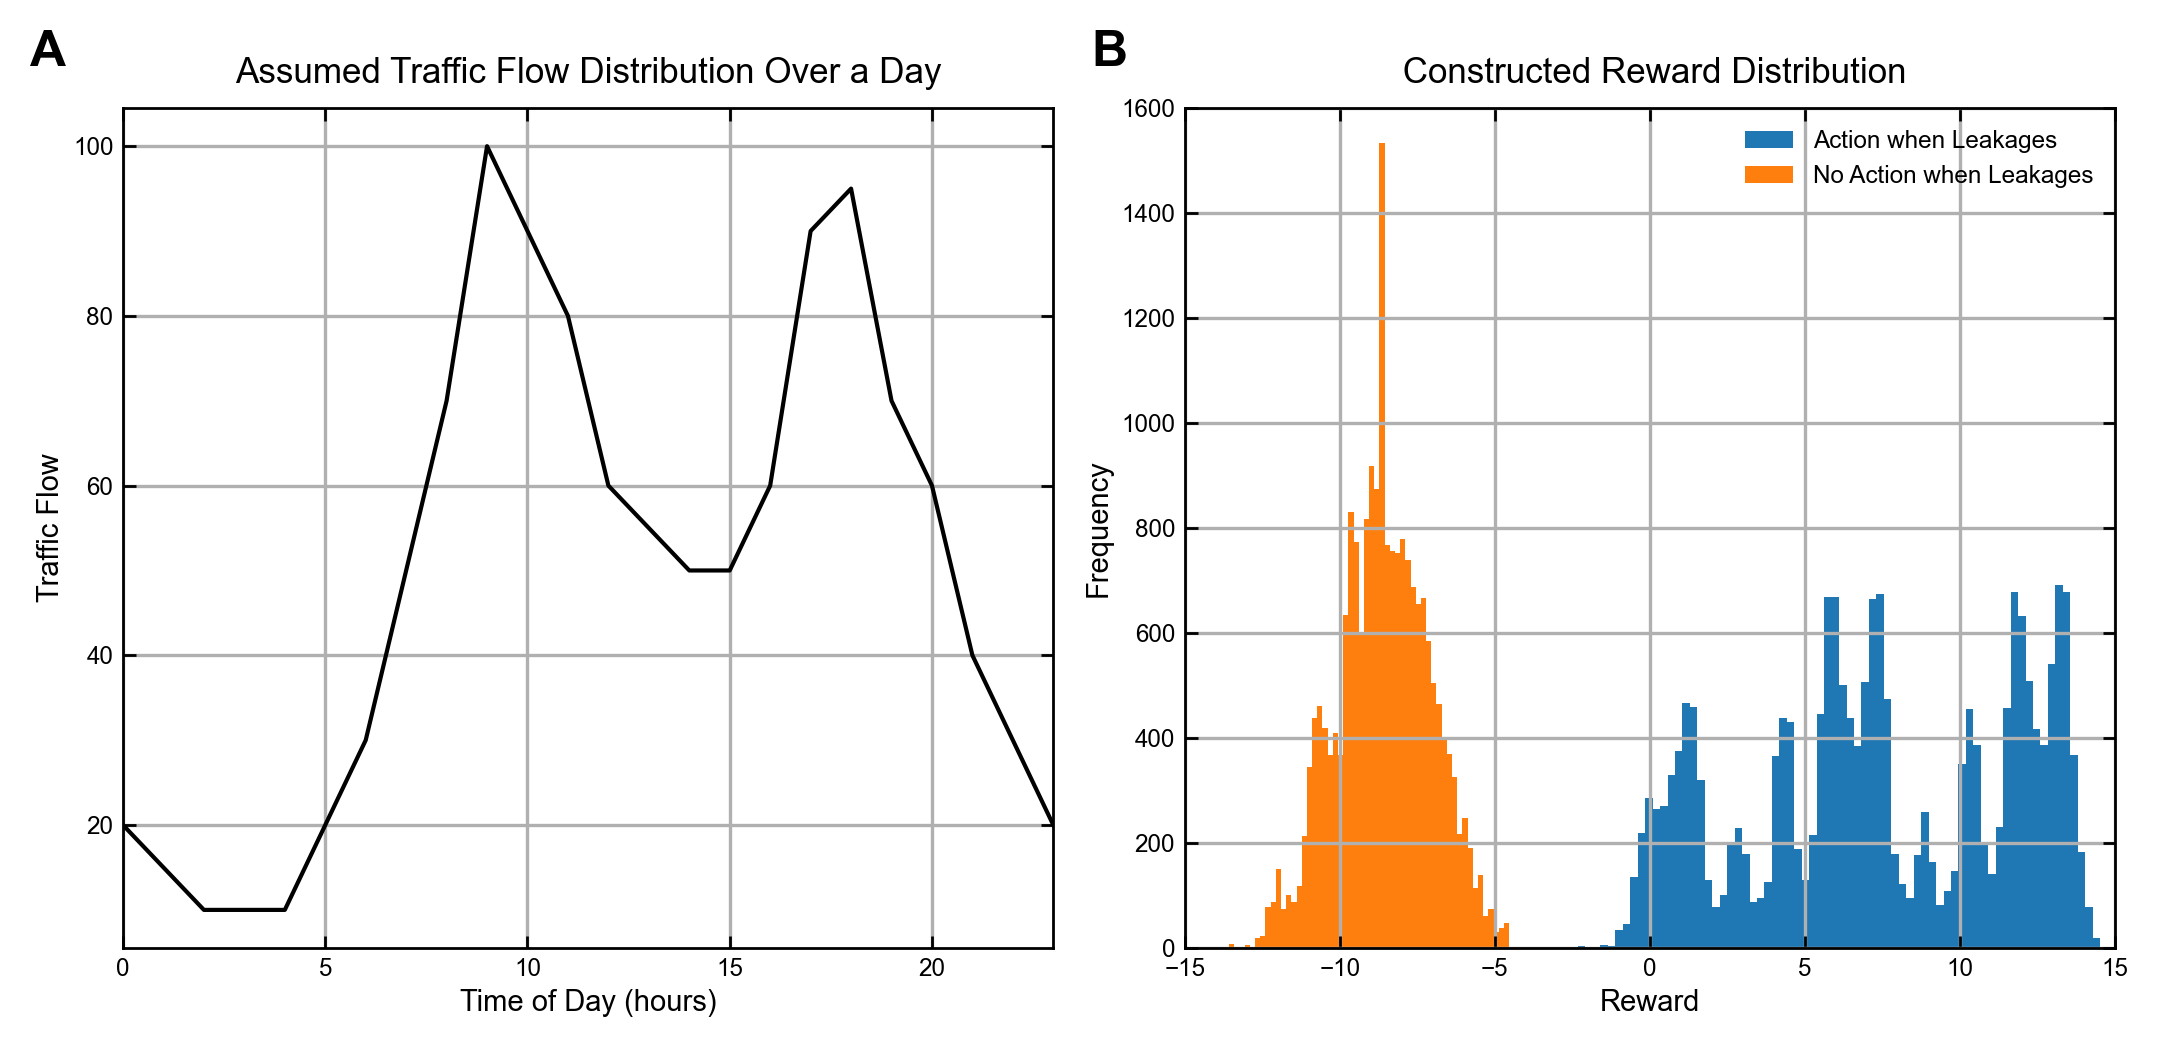

In [94]:
fig, ax = plt.subplots(1,2, figsize=(3.602361*2, 3.5),dpi=300)
time = np.arange(0, 24, 1)
ax[0].plot(time, traffic_flow, label='Traffic Flow', color='black')
ax[0].set_xlabel('Time of Day (hours)')
ax[0].set_ylabel('Traffic Flow')
ax[0].set_title('Assumed Traffic Flow Distribution Over a Day')
ax[0].grid(True)
ax[0].set_xlim(0, 23)

ax[1].grid(True)
ax[1].hist(dft2['a_total_award'], bins=80, label='Action when Leakages')

ax[1].hist(dft2['n_total_award'], bins=80, label='No Action when Leakages')
ax[1].set_title(' Constructed Reward Distribution') # 构建的奖励函数

# ax.set_yscale('log')
ax[1].set_xlabel('Reward')
ax[1].set_ylabel('Frequency')
ax[1].legend(frameon=False)
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 1600)
for i in range(2):
    # label A B 
    ax[i].text(-0.1, 1.05, chr(65+i), transform=ax[i].transAxes,
            size=12, weight='bold')

# save 
fig.savefig('figs/award_distribution.png')

## Test EnvComplexR

In [84]:
import src.env.env_basic as env_basic
import src.simulation.water_demands as wd

dft = wd.load(243, 12)

env = env_basic.EnvComplexR(dft)
env.reset()


(array([-0.01928942, -0.01883427,  0.00210519, -0.00350556,  0.00296355,
         0.0061122 , -0.03088086, -0.00671616,  0.00673889,  0.03825076]),
 {'step': 384})

In [85]:
for i in range(10000):
    r = env.step(0)[1]
    if r ==0.1:
        pass
    else:
        print(r)
        break

-9.18
